In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor, XGBRFRegressor

from imdb_movie_ratings.models import RatingsModel, StackedModel
from imdb_movie_ratings.utils import parse_and_join_data

warnings.filterwarnings("ignore")

### Read in cleaned and joined data
The scope of the analysis contains:
 - meta type of content: movie (no TV shows or others)
 - year range (using `startYear`): 1991 - 2020

The features we will be using (prior to modeling):
 - `tconst` (str): unique identifier of the movie
 - `year` (int): year when the movie is screened
 - `runtimeMinutes` (int): length of the movie
 - `genres` (categorical): the genre(s) the movie falls into
 - `local_score` (int): "localization score," determined by the number of localized versions
 - `n_uniq_cast` (int): number of unique categories among the cast/crew per movie
 - `numVotes` (int): total number of votes the movie receives
 - `averageRating` (float): average rating the movie receives

In [2]:
basic_kwargs = {
    "read_path": "../data/title.basics.tsv.gz",
    "title_type": "movie",
    "start_year": 1991,
    "end_year": 2020,
}
aka_kwargs = {"read_path": "../data/title.akas.tsv.gz"}
principal_kwargs = {"read_path": "../data/title.principals.tsv.gz"}
rating_kwargs = {"read_path": "../data/title.ratings.tsv.gz"}

In [3]:
joined_df = parse_and_join_data(basic_kwargs, aka_kwargs, principal_kwargs, rating_kwargs)
print(joined_df.shape)
joined_df.head()

(145130, 8)


,tconst,year,runtimeMinutes,genres,local_score,n_uniq_cast,averageRating,numVotes
0,tt0011216,2019,67,Drama,5,6,6.3,23
1,tt0015414,2000,60,\N,5,1,5.4,11
2,tt0015724,1993,102,"Drama,Mystery,Romance",4,8,6.0,21
3,tt0016906,2014,80,"Comedy,Musical",2,5,5.6,15
4,tt0019996,2011,94,\N,6,3,6.3,52


### Exploratory analysis
 - ratings vs. votes
 - correlation between numerical features
 - average ratings for 10 most popular genre by year

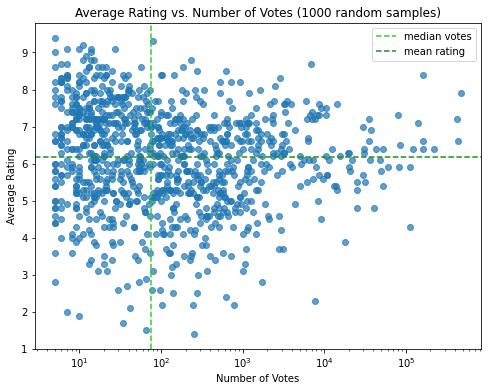

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
n_samples = 1000
ax.set_title(f"Average Rating vs. Number of Votes ({n_samples} random samples)")
sampled_idx = np.random.choice(joined_df.shape[0], n_samples)
ax.scatter(
    joined_df.loc[sampled_idx, "numVotes"],
    joined_df.loc[sampled_idx, "averageRating"],
    alpha=0.7,
)
ax.axvline(
    x=np.median(joined_df["numVotes"]),
    color="limegreen", ls="--",
    label="median votes",
)
ax.axhline(
    y=np.mean(joined_df["averageRating"]),
    color="forestgreen", ls="--",
    label="mean rating",
)
ax.set_xscale("log")
ax.set_xlabel("Number of Votes")
ax.set_ylabel("Average Rating")
legend_lines, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_lines, legend_labels)
plt.savefig("../figures/1_avg_rating_vs_num_votes.png", bbox_inches="tight")

The above plot indicates the relationship between `avgRating` (a value measure) and `numVotes` (a scale measure). Scale measures usually have long-tail distributions, hence the usage of median instead of mean as the axis splitter. Judging the plot, there does not seem to be a linear relationship between the two, but here are two observations:
1. Most popular movies (rightmost, quadrants I and IV) tend to have overall above-average ratings;
2. Niche movies (quadrants II and III) tend to have overall above-average ratings as well, since quadrant II looks denser than quadrant III.

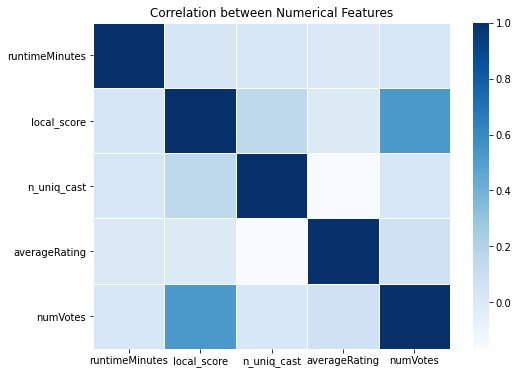

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title("Correlation between Numerical Features")
ax = sns.heatmap(
    joined_df.loc[:, "runtimeMinutes":"numVotes"].corr(),
    linewidth=0.5,
    cmap="Blues",
)
plt.savefig("../figures/2_corr_num_features.png", bbox_inches="tight")

From the above plot, we can see that `local_score` is highly correlated with `numVotes`, which makes sense given how the former indicates the geographical diversity of a movie's audience. It may be tempting to use `numVotes` in modeling, but in reality such a measure cannot be attained by the time we predict `averageRating`, as the values of both are accumulated over time. However, assuming the number of target markets is available by the time a movie is produced, we can use the localization score we computed as a proxy for the scale of said movie.

In [6]:
# Use one-hot encoding for genres, which is categorical
# Assuming all `genres` have been normalized (need no additional text wrangling)
joined_df["genres"] = joined_df["genres"].apply(lambda x: x.split(","))
dummy_genres = pd.get_dummies(joined_df["genres"].apply(pd.Series).stack()).sum(level=0)
dummy_genres.drop("\\N", axis=1, inplace=True)
genre_cols = list(dummy_genres.columns)
joined_df.drop("genres", axis=1, inplace=True)

movies = pd.concat([joined_df, dummy_genres], axis=1).sort_values(
    ["year", "tconst"]
).reset_index(drop=True)

In [7]:
# Take a look at the ratings by year for top 10 genres by N-count
top_10_genres = np.sum(movies[genre_cols], axis=0).sort_values(ascending=False).index[:10]
rating_aggs = []

for g in top_10_genres:
    df = movies[movies[g]==1].groupby("year", as_index=False).agg({"averageRating": np.mean})
    df["genre"] = g
    rating_aggs.append(df)

rating_aggs = pd.concat(rating_aggs, ignore_index=True).pivot(
    index="genre", columns="year", values="averageRating"
)
# Sort values by overall rating to make the visual prettier
rating_aggs = rating_aggs.iloc[np.argsort(np.sum(rating_aggs, axis=1).values)[::-1]]

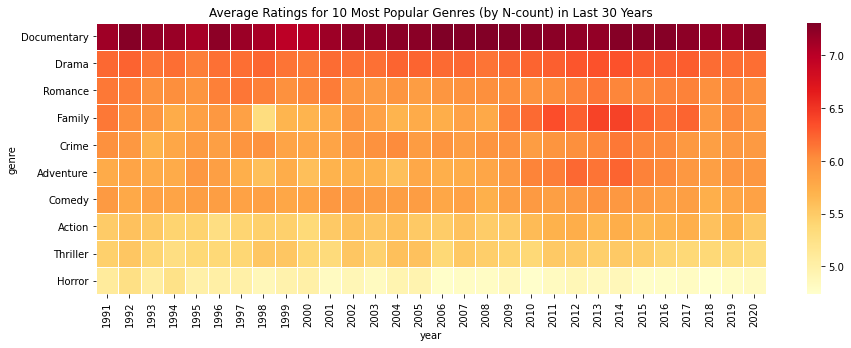

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Average Ratings for 10 Most Popular Genres (by N-count) in Last 30 Years")
ax = sns.heatmap(rating_aggs, linewidth=0.5, cmap="YlOrRd")
plt.savefig("../figures/3_avg_ratings_by_year_top_10.png", bbox_inches="tight")

Among the 10 most popular genres by N-count, `Documentary` stands out as being consistently highest rated. Ratings across the past three decades look stable for most of the genres, except `Family` and `Adverture`. `Horror` and `Thriller` are the lowest rated genres among the top 10, potentially due to their polarizing nature. In the following sections, we are going to use the numerical and genre features to train models to predict `averageRating`.

### Build XGBoost models and stacked model by year
Features that go into the model:
 - `runtimeMinutes`
 - `local_score`
 - `n_uniq_cast`
 - `genres` in one-hot encoded form

Dependent variable:
 - `averageRating`

Variable to split train and test:
 - `year`
 
Since we are building a predictive model, we cannot simply split the training set and test set randomly. For example, if we want to predict the `averageRating` of a 2020 movie, we cannot refer to 2021 data in our training. Thus, we have to split by `year`. Ideally, the `averageRating` should be measured by the same time window for each movie so as to eliminate the effects of recency bias (or vice versa). In this case, I will assume that such effects have already been eliminated / addressed in the data.

In [9]:
features = ["runtimeMinutes", "local_score", "n_uniq_cast"] + genre_cols
y_col = "averageRating"

Let's first benchmark the mean squared error (MSE) for the following three models:
 - an XGBoost model trained per year from scratch using all training data available
 - an XGBoost model trained per year from scratch using the last 20 years of data
 - an XGBoost model trained per year incrementally

In [10]:
year_range = range(2011, 2021)
MSEs_scratch = []

for yr in year_range:
    X_train = movies.loc[movies["year"]<yr, features].copy()
    y_train = movies.loc[movies["year"]<yr, y_col].copy()
    X_test = movies.loc[movies["year"]==yr, features].copy()
    y_test = movies.loc[movies["year"]==yr, y_col].copy()
    
    model = RatingsModel(XGBRegressor(n_estimators=10, n_jobs=-1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = model.get_mse(y_test, y_pred)
    MSEs_scratch.append(mse)

In [11]:
MSEs_last_20 = []

for yr in year_range:
    mask = (movies["year"]<yr) & (movies["year"]>=yr-20)
    X_train = movies.loc[mask, features].copy()
    y_train = movies.loc[mask, y_col].copy()
    X_test = movies.loc[movies["year"]==yr, features].copy()
    y_test = movies.loc[movies["year"]==yr, y_col].copy()
    
    model = RatingsModel(XGBRegressor(n_estimators=10, n_jobs=-1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = model.get_mse(y_test, y_pred)
    MSEs_last_20.append(mse)

In [12]:
incr_model = None
MSEs_incremental = []

for yr in year_range:
    if yr == 2011:
        X_train = movies.loc[movies["year"]<yr, features].copy()
        y_train = movies.loc[movies["year"]<yr, y_col].copy()
    else:
        X_train, y_train = X_test, y_test
    X_test = movies.loc[movies["year"]==yr, features].copy()
    y_test = movies.loc[movies["year"]==yr, y_col].copy()
    
    ratings_model = RatingsModel(
        XGBRegressor(n_estimators=10, n_jobs=-1)
    )
    # Pass incremental model to continuously train
    ratings_model.fit(X_train, y_train, xgb_model=incr_model)
    y_pred = ratings_model.predict(X_test)
    mse = ratings_model.get_mse(y_test, y_pred)
    MSEs_incremental.append(mse)
    # Log incremental model for the next iteration
    incr_model = ratings_model.model

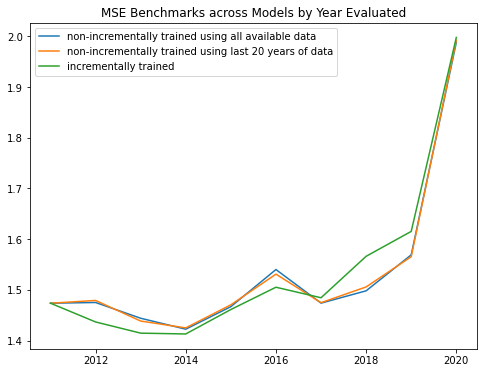

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title("MSE Benchmarks across Models by Year Evaluated")
ax.plot(year_range, MSEs_scratch, label="non-incrementally trained using all available data")
ax.plot(year_range, MSEs_last_20, label="non-incrementally trained using last 20 years of data")
ax.plot(year_range, MSEs_incremental, label="incrementally trained")
legend_lines, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_lines, legend_labels)
plt.savefig("../figures/4_model_MSE_benchmarks_1.png", bbox_inches="tight")

Judging the plot above, we can see that the two non-incrementally trained models perform almost identically, while the incrementally trained model performs better from 2012 to 2016 and worse elsewhere. We can scrap the non-incrementally trained model that uses all available data, because it yields similar performance to that of the other non-incremental model which uses less data. When it is hard to make the call on two models in which there is no clear winner, it is tempting to stack their predictions together and build another model that operates on top of those.

In [17]:
incr_model = None
MSEs_stacked = []
stacked_model = StackedModel(SGDRegressor())

for yr in year_range:
    mask = (movies["year"]<yr) & (movies["year"]>=yr-20)
    X_train_1 = movies.loc[mask, features].copy()
    y_train_1 = movies.loc[mask, y_col].copy()
    
    if yr == 2011:
        X_train_2 = X_train_1.copy()
        y_train_2 = y_train_1.copy()
    else:
        X_train_2, y_train_2 = X_test, y_test

    X_test = movies.loc[movies["year"]==yr, features].copy()
    y_test = movies.loc[movies["year"]==yr, y_col].copy()
    
    ratings_model_1 = RatingsModel(XGBRegressor(n_estimators=10, n_jobs=-1))
    ratings_model_2 = RatingsModel(XGBRegressor(n_estimators=10, n_jobs=-1))
    
    stacked_model.fit(
        model_1=ratings_model_1,
        X_1=X_train_1,
        y_1=y_train_1,
        model_2=ratings_model_2,
        X_2=X_train_2,
        y_2=y_train_2,
        kwargs_2={"xgb_model": incr_model}
    )
    
    y_pred = stacked_model.predict(X_test)
    mse = stacked_model.get_mse(y_test, y_pred)
    MSEs_stacked.append(mse)
    # Log incremental model for `model_2`
    incr_model = ratings_model_2.model

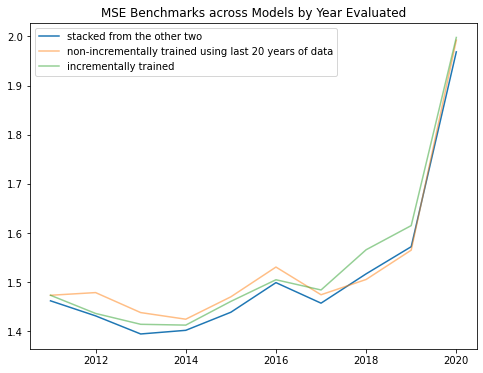

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title("MSE Benchmarks across Models by Year Evaluated")
ax.plot(year_range, MSEs_stacked, label="stacked from the other two")
ax.plot(year_range, MSEs_last_20, alpha=0.5, label="non-incrementally trained using last 20 years of data")
ax.plot(year_range, MSEs_incremental, alpha=0.5, label="incrementally trained")
legend_lines, legend_labels = ax.get_legend_handles_labels()
ax.legend(legend_lines, legend_labels)
plt.savefig("../figures/5_model_MSE_benchmarks_2.png", bbox_inches="tight")

By stacking the predicted outputs from the non-incremental and incremental models and incrementally training (i.e. `.partial_fit()`) an `SGDRegressor` (an elastic net-ish linear model by its default hyperparameters) using the stacked results as the input, we can effectively combine the merits between the two base models and produce overall better predicted results, except that 2020 hit every model like a truck.

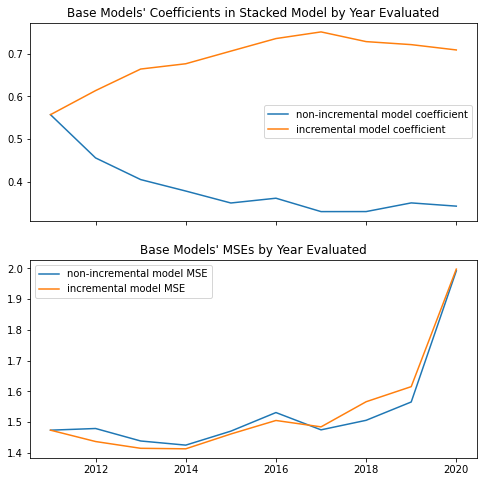

In [19]:
model_1_coefs, model_2_coefs = stacked_model.get_coefs()

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax1.set_title("Base Models' Coefficients in Stacked Model by Year Evaluated")
ax1.plot(year_range, model_1_coefs, label="non-incremental model coefficient")
ax1.plot(year_range, model_2_coefs, label="incremental model coefficient")
legend_lines, legend_labels = ax1.get_legend_handles_labels()
ax1.legend(legend_lines, legend_labels)
ax2.set_title("Base Models' MSEs by Year Evaluated")
ax2.plot(year_range, MSEs_last_20, label="non-incremental model MSE")
ax2.plot(year_range, MSEs_incremental, label="incremental model MSE")
legend_lines, legend_labels = ax2.get_legend_handles_labels()
ax2.legend(legend_lines, legend_labels)
plt.savefig("../figures/6_base_model_coefs_and_MSEs.png", bbox_inches="tight")

We can take a look at the coefficients in our stacked model, `SGDRegressor`, to get a sense of how the weights corresponding to each base model changed over time during training / testing. We should anticipate the coefficients to positively correlate with model performance / negatively correlate with MSE relative to a model's counterpart. The plot above confirms just that. Taking the incremental model for example, its coefficient keeps increasing in the first half until it gets outperformed by the non-incremental model, causing its coefficient to drop in the end. Similar pattern applies to the non-incremental model like the other side of the mirror.

### Discussion
In this exercise, I used the last three decades of movie data, put together a custom interface to implement XGBoost model and stacked model along with some ETL helper functions, and came up with a framework to continuously predict average ratings in the last decade. The results showed that there was no clear winner in a model trained on last 20 years of data (which preserves some recency bias) and a model trained incrementally (which preserves some historical bias). However, by combining their predicted outputs and trianing another model using the stacked output as the input, we can reduce the overall MSE by mitigating the biases of the base estimators and getting the best of both worlds.

If I had more time, I would dig deeper into the base estimators, the two XGBoost models, to get a sense of feature importance and how it changes over time (although the plots in the exploratory analysis section kind of give us a sneak peek of that). Such libraries as `SHAP` and `CausalML` could potentially lead to interesting and meaningful directions. I also did not bother with hyperparameter tuning with the interest of time and computational resources, but that could potentially help us further improve our model accuracy.